In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [75]:
before=pd.read_excel('Full_before_knn.xlsx')

In [76]:
present=pd.read_excel('Full_present_knn.xlsx')

In [77]:
before_copy=before.copy()

In [78]:
present_copy=present.copy()

In [79]:
before.drop(columns=['Unnamed: 0','ID','Spending_kind_Before'],inplace=True)
present.drop(columns=['Unnamed: 0','ID','Spending_kind_Present'],inplace=True)

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [81]:
before_scaled=pd.DataFrame(scaler.fit_transform(before),columns=before.columns)

In [82]:
# Two different scalers are used as scaler remembers the data shape(different shapes of two dataframes).
# This will help us in the inverse transform application after having clusters formed.
scaler2=MinMaxScaler()

In [83]:
present_scaled=pd.DataFrame(scaler2.fit_transform(present),columns=present.columns)

## Kmeans

To achieve our objective, the target variable is dropped, which might result in clusters based on spending kind. The moto over
here is to identify the number of personality traits we have before the pandemic and current and study them closely, and observe the dominant personality traits,therefore we are expecting around 4-6 clusters.

Initially K-Means with k-means++ initialization was adopted.

#### Why k-means++ and how it works

In the case of finding initial centroids using K-Means clustering, we were using randomization. The initial k-centroids were picked randomly from the data points.

This randomization of picking k-centroids points results in the problem of initialization sensitivity. This problem tends to affect the final formed clusters. The final formed clusters depend on how initial centroids were picked.

Kmeans++ is a smart initialization technique which computes distances from all point to the selected centriods. Then chooses a point as the new centroid that has maximum probability proportional to the distances. Repetation of these steps is performed to 
find optimal k.

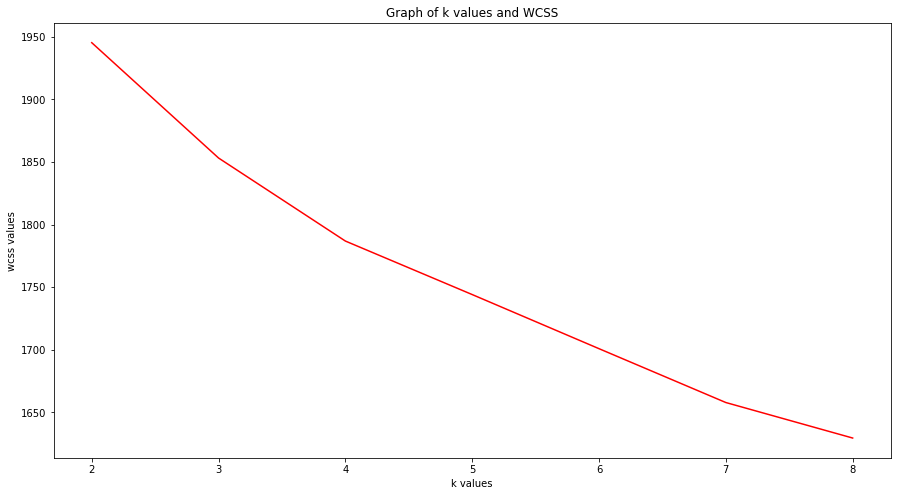

In [11]:
from sklearn.cluster import KMeans


x = before_scaled.copy()
wcss = []

for i in range(2, 9):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 3000, n_init = 10,random_state=0)
    km.fit(x)
    wcss.append(km.inertia_)
    
# Visualization of k values:

plt.figure(figsize=(15,8))
plt.plot(range(2,9), wcss, color='red')
plt.title('Graph of k values and WCSS')
plt.xlabel('k values')
plt.ylabel('wcss values')
plt.show()

In [12]:
# Int the above elbow plot variation in slope is reducing at value 5.

km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 1000, n_init = 30)
km.fit(x)
y_means=km.predict(x)

In [13]:
from sklearn.metrics import silhouette_score
silhouette_score(x,y_means)

0.06634662606004414

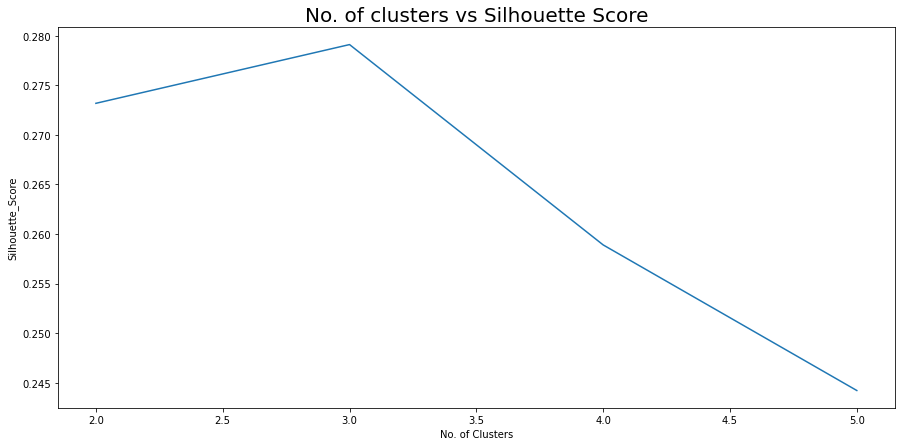

In [17]:
# The score here is very less which tells us that the clusters are overlapping.
# Hence we adopted a different approach of selecting fewer features that we consider important and indicative of the individuals personality.
# Also we have tried a combination of them with varying parameters(MAX_ITER,N_INIT).
#below is the best combination which we have achieved.

x3=before[['Worry_health_Before','Smoking_hab_Before','Drinking_hab_Before','Sleeping_hab_Before',
                  'Healthy_Lifestyle_Before','Food_pref_Before']]
data_copy1 = before_scaled.copy()

wcss = []

for i in range(2, 6):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 1000, n_init = 10,random_state=0)
    km.fit(x3)
    y_means=km.predict(x3)
    s=silhouette_score(x3,y_means)
    wcss.append(s)
    
plt.figure(figsize=(15,7))
plt.plot(range(2, 6), wcss)
plt.title('No. of clusters vs Silhouette Score', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette_Score')
plt.show()

Maximum sillhouette score is 0.28 with 3 clusters, with an inertia 1515.73 which is optimal.

From all of the above results it is evident that mostly clusters are overlapping with low sillhouette scores
(heterogenity) and also are not dense, which indicates that people's personality traits are not that similar to
actually group together in a cluster.

## HIERARCHIAL CLUSTERING (AGGLOMERATIVE CLUSTERING)

we have tried all other linkage methods and checked with centriods but only ward linkage, although having low copehentic score, it was able to from clusters in a distinctive manner.

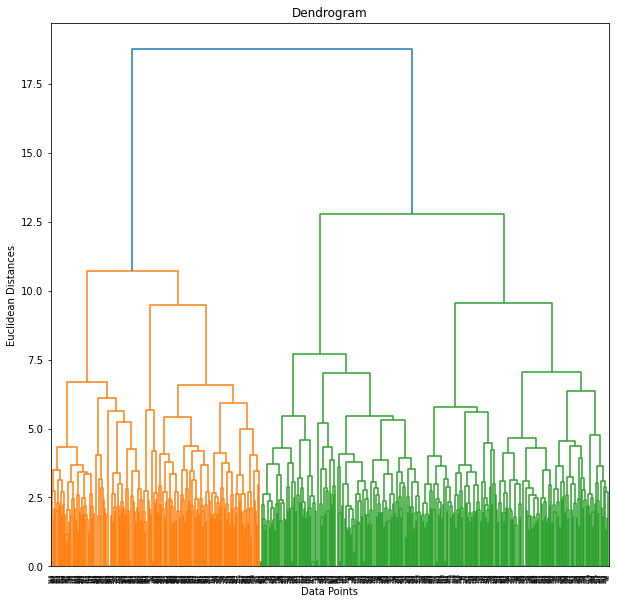

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram,cophenet
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram 


plt.figure(figsize=[10,10]) 
merg = linkage(before_scaled, method='ward') 
dendrogram(merg, leaf_rotation=90) 
plt.title('Dendrogram') 
plt.xlabel('Data Points') 
plt.ylabel('Euclidean Distances') 
plt.savefig('dendogram.png') 
plt.show() 

- Silhouette score still remained very low when all features, hence above method of performing clustering on selective features was adopted.
- Similar results as K Means was notices here, which makes sense as ward linkage works similar to the K Means algorithm

In [22]:
x3=before_scaled[['Worry_health_Before','Smoking_hab_Before','Drinking_hab_Before','Sleeping_hab_Before',
                  'Healthy_Lifestyle_Before','Food_pref_Before']]

hc2 = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean')
y_hc2 = hc2.fit_predict(x3)

In [23]:
silhouette_score(x3,y_hc2)

0.30000035008731357

## KModes

As all the above methods use euclidean distance as their primary metric, Kmodes is one such technique which uses only hamming distance to measure distance between points. Kmeans is one exclusive clsutering method for dataset with all categorical features, where it selects centriods based on the points frequency of occurance.

In [84]:
from kmodes.kmodes import KModes

In [85]:
#convert dataframe into array as the kmodes algorithm accepts numpy array as input.
per = np.array(before_scaled)

In [86]:
#We dont have any automated technique to check the ideal no of cluster for this technique.
#hence a manual iteration needs to be performed over here.
#initially we give a large value for clusters and then iterate over there centriods.
#Cost is indicating factor over here that the clusters formed are packed or not.
#our main objective in this iteration is to identify ideal k number where cost is minimum.
# 'Huang' here is probablistic method which of selecting modes in the data.

km1 = KModes(n_clusters=250,max_iter=1000,init='Huang',n_init=2,
            n_jobs=-1)

m2 = km1.fit(per)
m2.cost_ 

4098.0

In [87]:
mdl2 = m2.cluster_centroids_
km2 = KModes(n_clusters=125,max_iter=1000,init='Huang',n_init=2,
            n_jobs=-1)

m3= km2.fit(mdl2)
m3.cost_

2037.0

In [88]:
mdl3 = m3.cluster_centroids_
km3 = KModes(n_clusters=62,max_iter=1000,init='Huang',n_init=2,
            n_jobs=-1)

m4= km3.fit(mdl3)
m4.cost_

1040.0

In [89]:
mdl4 = m4.cluster_centroids_
km4 = KModes(n_clusters=31,max_iter=1000,init='Huang',n_init=2,
            n_jobs=-1)

m5 = km4.fit(mdl4)
m5.cost_

516.0

In [90]:
#As the number of cluster input number decreases, 'Huang' is replaced with 'Cao' which selected cluster based on their density.
#This is done as the cluster number decreases, probablitic method doesnot give fruitful results. 
mdl4 = m4.cluster_centroids_
km4 = KModes(n_clusters=31,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m5 = km4.fit(mdl4)
m5.cost_

498.0

In [91]:
mdl5 = m5.cluster_centroids_
km5 = KModes(n_clusters=15,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m6 = km5.fit(mdl5)
m6.cost_

270.0

In [92]:
mdl5 = m5.cluster_centroids_
km5 = KModes(n_clusters=15,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m6 = km5.fit(mdl5)
m6.cost_

270.0

In [93]:
mdl6 = m6.cluster_centroids_
km7 = KModes(n_clusters=7,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m7 = km7.fit(mdl6)
m7.cost_

142.0

In [94]:
mdl7 = m7.cluster_centroids_
km7 = KModes(n_clusters=5,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m8 = km7.fit(mdl7)
m8.cost_

34.0

In [95]:
mdl8 = m8.cluster_centroids_
km8 = KModes(n_clusters=4,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m9 = km8.fit(mdl8)
m9.cost_

21.0

In [96]:
mdl9 = m9.cluster_centroids_
km9 = KModes(n_clusters=3,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m10 = km9.fit(mdl9)
m10.cost_

16.0

In [97]:
#As we can observe that at 4 clusters the cost was minimum which indicates that the 4 is the ideal k number.
#Hence there are 4 type of personalities in the data.
#COST is the only metric for kmodes, hence silhouette score is not considered here.
#As Kmodes used frequency of occurance of data points, and also uses hamming distance, kmodes was chosen was final model.

#Lets study the clusters

modes_before=m9.fit_predict(before_scaled)

In [98]:
#A dataframe was created for cluster centriods, to study personalities.
clusters=pd.DataFrame()

In [99]:
clusters['features']=before_scaled.columns
clusters['cluster1']=m9.cluster_centroids_[0]
clusters['cluster2']=m9.cluster_centroids_[1]
clusters['cluster3']=m9.cluster_centroids_[2]
clusters['cluster4']=m9.cluster_centroids_[3]

In [100]:
clusters=clusters.transpose()

In [101]:
new_header = clusters.iloc[0] 
clusters = clusters[1:] 
clusters.columns = new_header

In [102]:
clusters

features,Age,Income,Emp_stat_Before,Gender,Marital_status,Loc,Notice_things_Before,All_angles_Before,Sincere_prod_Before,Lonely_Before,...,Food_pref_Before,Mode_of_transport_Before,Basic_medications_Before,Digital_content_Before,Active_Investor_Before,Edu_instit_fee_Before,Spend_on_gadgets_Before,spend_on_Luxury_Before,Track_Household_exp_Before,Domestic_help_Before
cluster1,0,0,0.6,0.5,0,0.5,0.75,0.75,0.75,0.25,...,1,0.5,1,0,0.25,0.75,0.5,0.5,1,0.333333
cluster2,0.8,0.6,0.6,0,1,0.5,0.5,0.5,0.75,0.25,...,1,0,0.5,0.5,0.5,0.5,0.5,0.5,1,0.333333
cluster3,0,0.8,0.6,0,1,0.5,1,1,1,0,...,0,0.5,1,1,0.5,1,0.5,1,1,0.5
cluster4,0,0,0.6,0,0,0.5,0.75,0.75,0.75,0,...,0,1,0,0,0,0.75,0.75,1,0,0.166667


In [103]:
#As we have cluster centriods in scaler version, we have to inverse transform them.
#As the inverse transform can be performed only the dataframe size on which transform was performed, we have tried an approach over here.
#We drop last 4 rows of a copy dataframe of before dataframe and perform inverse transfrom on it.

copy=before_scaled.copy()
copy.drop(index=[517,518,519,520],inplace=True)

In [104]:
# Now merging the cluster centriods in place of those last few rows.
scaled=pd.merge(copy,clusters,how='outer')

In [105]:
#After inverse transform we can study clusters centriods based on their responses and define personalities. 
pd.DataFrame(data=scaler.inverse_transform(scaled),columns=scaled.columns).iloc[517:].T

,517,518,519,520
Age,0.0,4.0,0.0,0.0
Income,0.0,3.0,4.0,0.0
Emp_stat_Before,3.0,3.0,3.0,3.0
Gender,1.0,0.0,0.0,0.0
Marital_status,0.0,1.0,1.0,0.0
Loc,1.0,1.0,1.0,1.0
Notice_things_Before,4.0,3.0,5.0,4.0
All_angles_Before,4.0,3.0,5.0,4.0
Sincere_prod_Before,4.0,4.0,5.0,4.0
Lonely_Before,2.0,2.0,1.0,1.0


In [106]:
# lets study the proportion of centriods.
before['before_cluster']=modes_before 
#adding back ID and Spending kind.
before['ID']=before_copy['ID'] 
before['Spending_kind_Before']=before_copy['Spending_kind_Before']

In [107]:
before['before_cluster'].value_counts()

0    216
1    124
3    104
2     77
Name: before_cluster, dtype: int64

In [108]:
before.groupby('before_cluster')['Spending_kind_Before'].value_counts()  

before_cluster  Spending_kind_Before
0               1                       161
                0                        31
                2                        24
1               1                        90
                2                        21
                0                        13
2               1                        58
                2                        12
                0                         7
3               1                        64
                2                        31
                0                         9
Name: Spending_kind_Before, dtype: int64

As we can observe clsuters were formed basis on their personality and not basis on spending kind, which can be seen in the above value counts w.r.t spending kind.

#### Present dataset

Similar steps of Kmeans and Agglomerative techniques were performed on present data as well and similar results were noticed.

Silouette scores for different models is below:

- 0.05 for all featuers model in kmeans.
- 0.28 for selected featueres model in kmeans.
- 0.06 for all features model in agglomerative.
- 0.28 for selected features model in agglomerative.

As K modes was selected as final model, same steps are performed on the present dataset below.

In [109]:
per_pre = np.array(present_scaled)

In [110]:
km1 = KModes(n_clusters=250,max_iter=1000,init='Huang',n_init=2,
            n_jobs=-1)

m2 = km1.fit(per_pre)
m2.cost_

3990.0

In [111]:
mdl2 = m2.cluster_centroids_
km2 = KModes(n_clusters=125,max_iter=1000,init='Huang',n_init=2,
            n_jobs=-1)

m3= km2.fit(mdl2)
m3.cost_

2099.0

In [112]:
mdl3 = m3.cluster_centroids_ 
km3 = KModes(n_clusters=62,max_iter=1000,init='Huang',n_init=2,
            n_jobs=-1)

m4= km3.fit(mdl3)
m4.cost_

1108.0

In [113]:
mdl4 = m4.cluster_centroids_
km4 = KModes(n_clusters=31,max_iter=1000,init='Huang',n_init=2,
            n_jobs=-1)

m5 = km4.fit(mdl4)
m5.cost_

572.0

In [114]:
mdl4 = m4.cluster_centroids_
km4 = KModes(n_clusters=31,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m5 = km4.fit(mdl4)
m5.cost_

548.0

In [115]:
mdl5 = m5.cluster_centroids_
km5 = KModes(n_clusters=15,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m6 = km5.fit(mdl5)
m6.cost_

286.0

In [116]:
mdl6 = m6.cluster_centroids_
km7 = KModes(n_clusters=7,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m7 = km7.fit(mdl6)
m7.cost_

145.0

In [117]:
mdl7 = m7.cluster_centroids_
km7 = KModes(n_clusters=5,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m8 = km7.fit(mdl7)
m8.cost_

43.0

In [118]:
mdl8 = m8.cluster_centroids_
km8 = KModes(n_clusters=4,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m9 = km8.fit(mdl8)
m9.cost_

24.0

In [119]:
mdl9 = m9.cluster_centroids_
km9 = KModes(n_clusters=3,max_iter=1000,init='Cao',n_init=2,
            n_jobs=-1)

m10 = km9.fit(mdl9)
m10.cost_

24.0

In [120]:
modes_pre=m9.fit_predict(present_scaled)

In [121]:
clusters_pre=pd.DataFrame()

In [122]:
clusters_pre['features']=present_scaled.columns
clusters_pre['cluster1']=m9.cluster_centroids_[0]
clusters_pre['cluster2']=m9.cluster_centroids_[1]
clusters_pre['cluster3']=m9.cluster_centroids_[2]
clusters_pre['cluster4']=m9.cluster_centroids_[3]

In [123]:
clusters_pre=clusters_pre.transpose()
new_header_pre = clusters_pre.iloc[0] 
clusters_pre = clusters_pre[1:] 
clusters_pre.columns = new_header_pre

In [124]:
clusters_pre

features,Age,Income,Emp_stat_Present,Gender,Marital_status,Loc,Notice_things_Present,All_angles_Present,Sincere_prod_Present,Lonely_Present,...,Mode_of_transport_Present,Basic_medications_Present,Digital_content_Present,Active_Investor_Present,Edu_instit_fee_Present,Change_in_data_consumption,Spend_on_gadgets_Present,Spend_on_Luxury_Present,Track_Household_exp_Present,Domestic_help_Present
cluster1,0,0,0.6,0.5,0,0.5,0.75,0.75,0.75,0.75,...,1,1,1,0,0.75,1,0.5,0,1,0.333333
cluster2,0,0.6,0.6,0,0,0.5,0.75,0.75,0.75,0.25,...,1,0.5,0.5,0.25,0.5,1,0.5,0.5,1,0.333333
cluster3,0,0.4,0.6,0,0,0.5,1,1,1,0.5,...,0.5,1,1,0.25,0.5,1,0.5,0.5,1,0.333333
cluster4,0.8,0,0.6,0,1,0.5,1,1,1,0,...,1,1,1,0.5,1,1,0.5,0,1,0.666667


In [125]:
copy_pre=present_scaled.copy()
copy_pre.drop(index=[517,518,519,520],inplace=True)

In [127]:
scaled_present=pd.merge(copy_pre,clusters_pre,how='outer')

In [128]:
pd.DataFrame(scaler2.inverse_transform(scaled_present),columns=scaled_present.columns).iloc[517:].T

,517,518,519,520
Age,0.0,0.0,0.0,4.0
Income,0.0,3.0,2.0,0.0
Emp_stat_Present,3.0,3.0,3.0,3.0
Gender,1.0,0.0,0.0,0.0
Marital_status,0.0,0.0,0.0,1.0
Loc,1.0,1.0,1.0,1.0
Notice_things_Present,4.0,4.0,5.0,5.0
All_angles_Present,4.0,4.0,5.0,5.0
Sincere_prod_Present,4.0,4.0,5.0,5.0
Lonely_Present,4.0,2.0,3.0,1.0


In [129]:
present['Present clusters']=modes_pre
present['ID']=present_copy['ID']
present['Spending_kind_Present']=present_copy['Spending_kind_Present']

In [130]:
present['Present clusters'].value_counts()

0    237
1    116
3     93
2     75
Name: Present clusters, dtype: int64

In [131]:
present.groupby('Present clusters')['Spending_kind_Present'].value_counts()

Present clusters  Spending_kind_Present
0                 1                        141
                  0                         80
                  2                         16
1                 1                         77
                  0                         33
                  2                          6
2                 1                         48
                  0                         23
                  2                          4
3                 1                         56
                  0                         23
                  2                         14
Name: Spending_kind_Present, dtype: int64

By studying the clusters formed in both the sceanrio, similar personalities were change in proportion was noticed. Below are the inferences:

- Cluster 1:
    - These are very linenant poeple, very selective, not much outgoing people.
    - They were changes in few of their aspects but most interesting was they started feeling lonely after pandemic restrictions which was not the case before.
- cluster 2:
    - These are confused poeple, where most of their responses are neutral.
    - There was no change in these peoples personalities due to pandemic, as very negligible change in their responses was notieced.
- Cluster 3:
    - These are smart and balanced people, who have an opinion on everything and have smart interests and choices.
    - Few adjustments were adopted by these people due to pandemic, as they cut few unnecessary interests or remained neutral at them.
- cluster 4:
    - These are lazy and little bit irresponsible people.
    - Although few changes were noticed, but most of the responses remained same in these people, telling us that these personality types have remained almost same, even after pandemic restrictions.
    
Cluster 1 and 2 are noticed to be overlapping in few aspects, and likely Cluster 3 and 4 also are overlapping in few ascpects
Cluster 1 was dominant in the before pandemic and current sceanrio as well.

In [133]:
pd.crosstab(index=before['before_cluster'],columns=present['Present clusters'],margins=True,margins_name='Total')

Present clusters,0,1,2,3,Total
before_cluster,,,,,
0,103,43,35,35,216
1,52,30,16,26,124
2,33,16,14,14,77
3,49,27,10,18,104
Total,237,116,75,93,521


The above transition matrix gives us the shift between individuals from one personality type to other.

This also tells us that pandemic affected all clusters equally and many people have noticed a few changes in them.